# Hypothesis Testing, A/B Testing
---

Tonight we'll be conducting our own A/B test and extracting useful business insights!

In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You've just been hired as the Chief Data Scientist for CALPIRG.  You're being tasked with helping the UX (user experience) team tweak your website to try to get more people to pledge to Save the Bees™.  Here are the two strategies the team has come up with:
1. Have a pledge button and call-to-action on just the main page of the site
2. Have a popup with the pledge button and call-to-action whenever you visit the site

As a data scientist, it is your job to see which method is more effective at driving pledges (we'll simply call them "clicks").  It is also your job to create a compelling argument to convince CALPIRG to act in accordance to your findings.

Ready?  Let's begin.

# Step 0: Why do we do hypothesis testing?
---

Simply comparing the average of the two groups has a lot of room for error.

Have you ever heard of a difference being "*statistically significant*"?  We don't just want to see if there's a difference—we want to know if that difference is caused by something, or if it's even a significant difference in the first place!

We're able to determine if something is significant or not by hypothesis testing.

Hypothesis testing helps with the following:
* Figuring out the differences between two measurements when we're looking at a **sample** instead of the population
* Figuring out if a difference could have happened by random chance
* Establishing **causation** if we conducted an experiment

In [ ]:
# That last point is very important

# Step 1: Choosing our hypotheses
---

Recall, when conducting a hypothesis test we generate two hypotheses:

### The Null Hypothesis (H<sub>0</sub>):
States that nothing really changed.  Technically, it states that both of the samples came from the same population.

### The Alternative Hypothesis (H<sub>1</sub>):
States that there is a difference between the two distributions from which the samples were taken.

In [ ]:
# Alright, let's create our two hypotheses together

```
Null: Visitors who receive a popup will exhibit the same click rate as that of visitors who don't receive a popup.

Alt:  Visitors who receive a popup will exhibit a lower click rate as that of visitors who don't receive a popup.
```

In [ ]:
# It's important to be specific when working with statistics.

In [ ]:
# Let's create two more hypotheses:

```
Let c := the average click rate of visitors before the experiment (theoretically the same as control)

H_0: c_popup = c_control
H_1: c_popup < c_control "lower click rate"

or

H_0: c_popup = c_control
H_1: c_popup ≠ c_control "not the same"
```

# Step 2: Setting up the experiment
---

Now we need to figure out how to test this (and how to measure the results).

Since we are scientists, after all, it is important that we follow some rules when conducting experiements:
- The experiment must be controlled
- The experiment must have a treatment and control group
- The experiment must not be harmful
- The experiment must produce results that can evaluate a hypothesis
- The results must be reproducible (the experiment must be able to be repeated)

Well, I hope we're not harming anyone by showing them a few popups.  As for fulfilling the rest of the requirements, what do you think is a good way to create our experiment?

```
Every time someone visits the website, they have a 50% chance of either seeing a popup or not.

We keep track of which group (popup or not) the visitors were in, and whether or not they pledged.
```

Our experiment is a Random Controlled Trial (RCT), as opposed to an Observational Study.  What does this mean we can conclude from the results of the experiment?

```
We have the opportunity to establish causation.
```

# Step 3: Execute the experiment
---

Now we implement this experiment in the code for the website.  We need to make sure to record the results!

We received 1000 visitors over the last week, and kept track of which group they were in and whether they pledged.

`0 = Did not pledge; 1 = Pledged`

In [2]:
data = Table.read_table("popup-test.csv")

In [3]:
data

Group,Click
Control,0
Control,0
Control,0
Treatment,0
Treatment,1
Control,0
Control,1
Treatment,0
Control,0
Control,0


In [ ]:
# Is this the population?

```
This is a sample — not the population.
```

# Step 4: Test the null hypothesis
---

Let's establish something thing before we go any further:
- What is the statistic we are trying to test for?

In [ ]:
# What are we looking at between treatment and control?

```
We're looking at a difference in click rate (proportion of people who clicked "pledge")

Let's be specific: {control click rate} - {treatment click rate}
```

In [4]:
# Let's find that difference from our sample above
num_clicks = data.group("Group", sum)
num_clicks

Group,Click sum
Control,185
Treatment,170


In [5]:
group_counts = data.group("Group")
group_counts

Group,count
Control,476
Treatment,524


In [6]:
click_rates = Table().with_columns(
    "Group", ["Control", "Treatment"],
    "Rate", num_clicks.column("Click sum") / group_counts.column("count")
)
click_rates

Group,Rate
Control,0.388655
Treatment,0.324427


In [7]:
rates = click_rates.column("Rate")
observed_diff = rates.item(0) - rates.item(1)
observed_diff

0.06422798126884344

In [ ]:
# Does that seem like a big difference?

```
It's hard to tell!

That's where hypothesis testing comes in handy.
```

Now we are trying to figure out how likely it is to observe that distance or greater.

In [ ]:
# Why "that distance or greater"?  Why not "that distance"?

```
If we're saying that 6% is unlikely, then it follows that anything greater than 6% is even more unlikely.

The probability of getting exactly any distance is practically zero.  When we're working with continuous distributions (can take a value anywhere in a range) then we can only find probability of a range of values occurring — not a single value!
```

### A bit more detail into testing the null hypothesis

What is the null hypothesis?

> The popup has no effect.  The click rate for visitors who get the popup and for visitors who don't come **from the same population**.

Recall, when we run a hypothesis test we are **trying to prove the null hypothesis**.  How would we do that?

```
If the average click rate for visitors with a popup is the same for visitors without a popup, then:

It's reasonable for us to find the observed difference of 6%.
```

### Permutation test
All we have is a sample.  We have no other knowledge of our population.

So... how are we going to try and prove the null hypothesis?

```
No matter what group a visitor is assigned to, it's still reasonable for us to find the observed difference of 6%.
```

In [9]:
# Let's conduct the permutation test
trials = 1000
differences = make_array()

for i in range(trials):
    # We choose one of the columns, either the Group or the Click, to shuffle
    shuffled_groups = data.sample(with_replacement=False).column("Group")
    
    # Then we match it back up with our other column
    shuffled_data = Table().with_columns(
        "Group", shuffled_groups,
        "Click", data.column("Click")
    )
    
    # Now, we see what differences we get after shuffling
    click_rates = (
        shuffled_data.group("Group", sum).column("Click sum")
        / shuffled_data.group("Group").column("count")
    )
    
    difference = click_rates.item(0) - click_rates.item(1)
    
    differences = np.append(differences, difference)

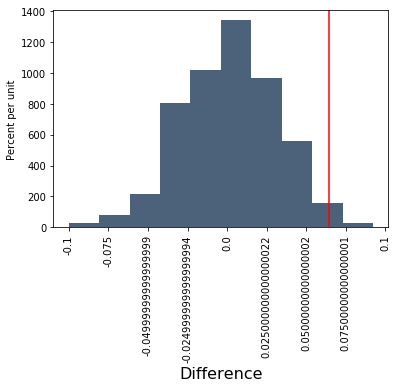

In [10]:
# Let's visualize the distribution of differences
Table().with_column("Difference", differences).hist()

# Where does our observed difference land?
plt.axvline(observed_diff, c='r')

In [ ]:
# Wow, that's more different than 6% would lead you to believe!

In [11]:
# What's the chance of a difference geq the observed difference occurring?
np.count_nonzero(np.array(differences) >= observed_diff) / len(differences)

0.015

### Another type of test
Let's say that we know the average click rate for visitors is 0.4.  Then, we can test the null hypothesis by simulation as opposed to permutation.

In [12]:
trials = 1000
visitors = 1000
differences = []

for i in range(trials):
    d = {"Control": {"visitors": 0, "clicks": 0}, "Treatment": {"visitors": 0, "clicks": 0}}
    
    for visitor in range(visitors):
        # 50% chance of being in treatment
        group = np.random.choice(["Treatment", "Control"])

        # 40% chance of clicking
        click = np.random.choice([1, 0], p=[0.4, 0.6])
        
        d[group]["visitors"] += 1
        d[group]["clicks"] += click
        
    rate_control = d["Control"]["clicks"] / d["Control"]["visitors"]
    rate_treatment = d["Treatment"]["clicks"] / d["Treatment"]["visitors"]
    difference = rate_control - rate_treatment
    
    differences.append(difference)

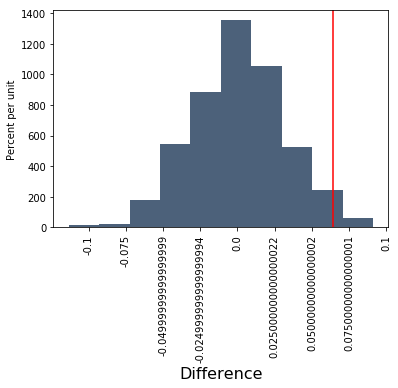

In [13]:
# Visualize again
Table().with_column("Difference", differences).hist()
plt.axvline(observed_diff, c='r')

In [14]:
np.count_nonzero(np.array(differences) >= observed_diff) / len(differences)

0.025

# Step 5: Interpret the results
---

In order to interpret the results, and figure out whether or not the observed difference was statistically significant, we need to set a significance level, **<code>&alpha;</code>**.

The significance level is defined as the probability of making a "Type I Error" in which we reject the null hypothesis when it is actually true.  Meaning, if we set $\alpha = 0.05$ then we have 5% chance of mistakenly rejecting the null hypothesis.


From our experiment, we calculate a **<code>p-value</code>**.

The p-value is the defined as the probability of finding a difference greater than or equal to the observed difference — provided that the null hypothesis is true.

In [ ]:
# What is the p-value of our experiment above?
# (based on the permutation test)

In [15]:
0.015

0.015

If the p-value is less than or equal to the significance level, then we reject the null hypothesis and support the alternative hypothesis.

In [ ]:
# Since this is an experiment, what does supporting the alternative hypothesis imply?

```
It means that we establish causation, since this was an experiment.
```

In [16]:
# If the p-value is greater than the significance level, then we...

```
If p > 𝛼, then we **fail to reject** the null hypothesis — we don't ever "support" it!
```

So, now it's time to prepare our presentation to CALPIRG:

---

In order to get more people to pledge while visiting the website, we should:
NOT show popups.

We concluded this from
an experiment

in which we assigned
50% of visitors to receive a popup.

We collected
their group and whether the pledged

and saw
that the average click rate for popups was 6% lower than for no popup

We proposed two hypotheses:
- The average click rate for popup and not is actually the same
- The average click rate for popup is lower than for no popup

After running a
hypothesis test

we discovered that the observed difference
was statistically significant

So, we
rejected the null hypothesis

because our p-value
was less than &alpha; = 0.05

And, therefore
we were less than 5% likely to have seen the observed difference due to random chance alone

In conclusion,
don't show popups.  They CAUSE a lower click rate.

# Have a great Thanksgiving!